In [1]:
import bioframe
import pandas as pd
import numpy as np
import tensorflow as tf
from basenji import dna_io
import akita_utils

2022-10-15 11:52:30.803710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /spack/apps/linux-centos7-x86_64/gcc-8.3.0/python-3.9.2-uvcroioc4witkp6qf7mbebof5ix4wlb6/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/pmix-3.1.3-3sm6emyqaxapunh7rwbjvtaqoqe2e5z3/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openmpi-4.0.2-ipm3dnvlbtxawpi4ifz7jma6jgr7mexq/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openblas-0.3.8-2no6mfziiclwxb7lstxoos335gnhjpes/lib:/spack/apps/gcc/8.3.0/lib64::/home1/smaruj/software/GSL/lib:/home1/smaruj/software/HTSLIB/lib
2022-10-15 11:52:30.803771: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 13})

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  

In [3]:
filename = "/home1/smaruj/akita_utils/bin/insert_virtual_spacing_experiment/data/2022-10-11_200_10W_10S_spacings_0-1000_right_bg1234.h5"
scd_stats = ["SCD", "INS-16"]

In [4]:
df = akita_utils.h5_to_df(filename, scd_stats, drop_duplicates_key=None)

In [5]:
is_strong = lambda x : True if (x > 20) else False

df["strong"] = df["genomic_SCD"].apply(is_strong)

In [6]:
get_seq_index = lambda x : (x % 20)

df["seq_index"] = df["experiment_id"].apply(get_seq_index)

In [7]:
def average_over_targets(dataframe, stat, mouse=True, model=1):
    
    num_targets = 6
    if not mouse:
        num_targets = 5
    
    collist = [stat + f"_h{int(mouse)}_m{model}_t{i}" for i in range(num_targets)]
    
    dataframe[f"{stat}_average"] = dataframe[collist].mean(axis=1)
    
    return dataframe

In [8]:
for stat in scd_stats:
    df = average_over_targets(df, stat)

In [9]:
target_dict = {"0" : "mESC_uC",
              "1" : "mESC",
              "2" : "CN",
              "3" : "ncx_CN",
              "4" : "NPC",
              "5" : "ncx_NPC"} 

In [10]:
orientation_vs_spacer = df.groupby(["strong", "orientation", "spacer_bp"]).agg({"SCD_average": "mean"}).reset_index()

In [11]:
spacing_list = list(np.unique(orientation_vs_spacer["spacer_bp"]))

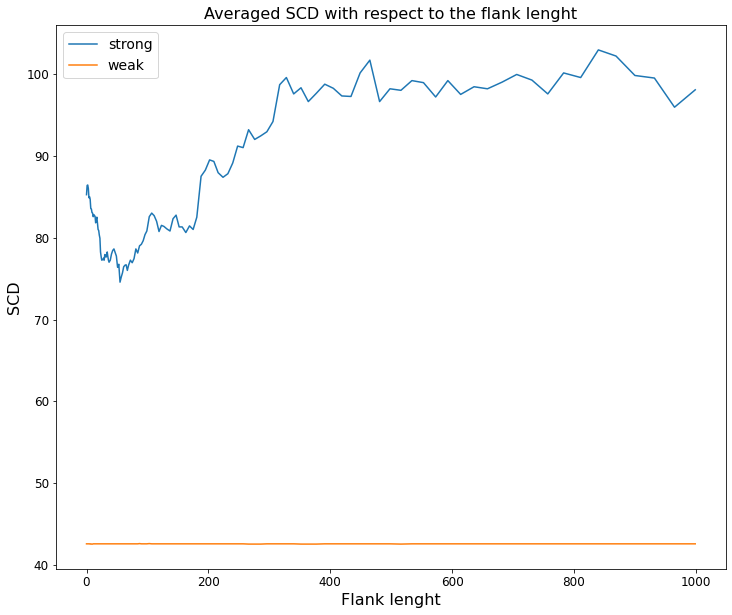

In [13]:
plt.figure(figsize=(12,10))
x = spacing_list


plt.plot(x, orientation_vs_spacer[orientation_vs_spacer["strong"] == True]["SCD_average"], 
         label="strong")

plt.plot(x, orientation_vs_spacer[orientation_vs_spacer["strong"] == False]["SCD_average"], 
         label="weak")
    
plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Flank lenght")
plt.ylabel("SCD")
plt.legend(loc="upper left")
# plt.legend(bbox_to_anchor=(1.35, 1.015), loc='upper right', ncol=1)
plt.savefig("averaged_SCD.png")

In [14]:
background_vs_orientation_vs_spacing = df.groupby(["strong", "background_index", "orientation", "spacer_bp"]).agg({"SCD_average": "mean"}).reset_index()

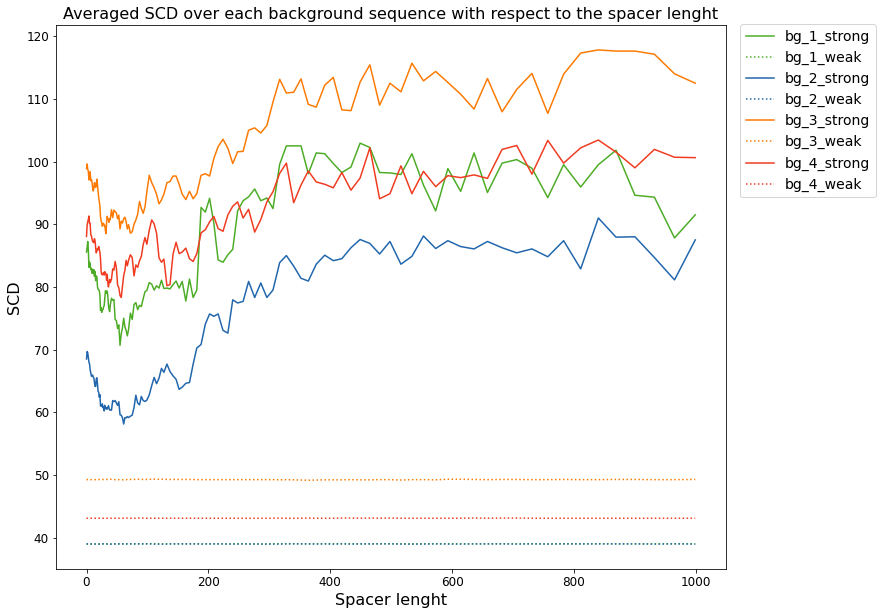

In [27]:
background_colors = ["#4dac26", "#2166ac", "#fc7a02", "#f03b20"]

plt.figure(figsize=(12,10))
x = spacing_list

for background_idx in [1, 2, 3, 4]:
    plt.plot(x, background_vs_orientation_vs_spacing[(background_vs_orientation_vs_spacing["background_index"] == background_idx) & (background_vs_orientation_vs_spacing["strong"] == True)]["SCD_average"],
                 "-",
                 c=background_colors[background_idx-1],
                 label=f"bg_{background_idx}_strong")
    plt.plot(x, background_vs_orientation_vs_spacing[(background_vs_orientation_vs_spacing["background_index"] == background_idx) & (background_vs_orientation_vs_spacing["strong"] == False)]["SCD_average"],
                 ":",
                 c=background_colors[background_idx-1],
                 label=f"bg_{background_idx}_weak")

plt.legend(loc="upper right")
plt.title("Averaged SCD over each background sequence with respect to the spacer lenght")
plt.xlabel("Spacer lenght")
plt.ylabel("SCD")
# plt.legend(loc="upper left")
plt.legend(bbox_to_anchor=(1.235, 1.015), loc='upper right', ncol=1)
plt.savefig("backgrounds_SCD.png", bbox_inches="tight")

## Taking median over the backgrounds

In [17]:
columns_to_take_median = ["INS-16_h1_m1_t0", "INS-16_h1_m1_t1", "INS-16_h1_m1_t2", "INS-16_h1_m1_t3", "INS-16_h1_m1_t4", "INS-16_h1_m1_t5",
                          "SCD_h1_m1_t0", "SCD_h1_m1_t1", "SCD_h1_m1_t2", "SCD_h1_m1_t3", "SCD_h1_m1_t4", "SCD_h1_m1_t5",
                          "SCD_average", "INS-16_average"]
median_list = ["median" for i in range(len(columns_to_take_median))]

dictionary_to_median = dict(zip(columns_to_take_median, median_list))

In [18]:
new_df = df.groupby(["strong", "orientation","spacer_bp", "seq_index"]).agg(dictionary_to_median).reset_index()

In [19]:
strong_targets = ["#F20808", "#1119EF", "#09DAE9", "#13F238", "#EC9018", "#E80ACA"]
weak_targets = ["#E65A5A", "#7B7EDB", "#AAEAEF", "#98F0A7", "#EEBE80", "#E69FDD"]

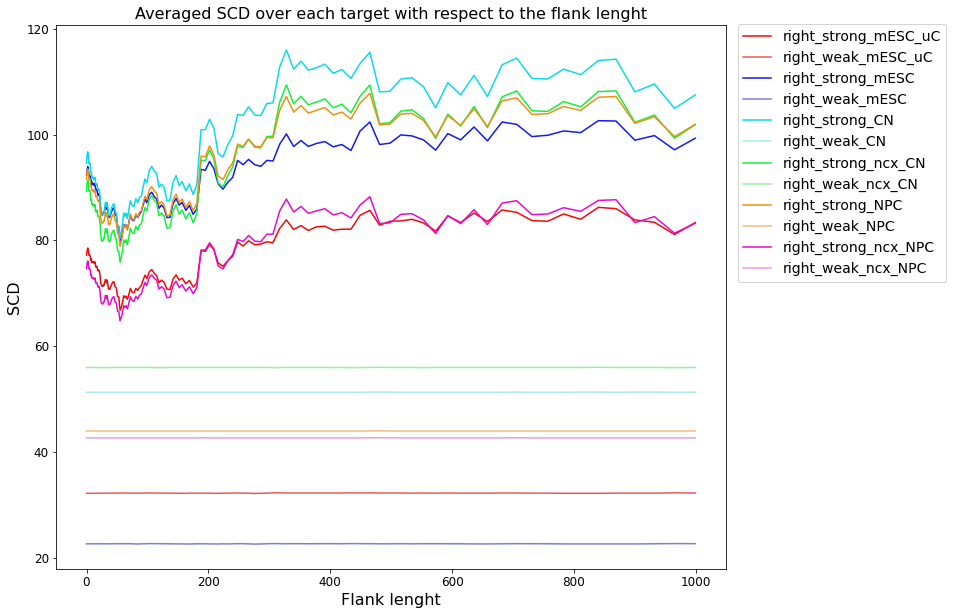

In [25]:
plt.figure(figsize=(12,10))
x = spacing_list

for target_idx in range(6):
    target_vs_orientation_spacer = new_df.groupby(["strong", "orientation", "spacer_bp"]).agg({f"SCD_h1_m1_t{target_idx}": "mean"}).reset_index()
    plt.plot(x, target_vs_orientation_spacer[(target_vs_orientation_spacer["strong"] == True)][f"SCD_h1_m1_t{target_idx}"],
                 label=f"right_strong_{target_dict[str(target_idx)]}", 
                 c=strong_targets[target_idx])
    plt.plot(x, target_vs_orientation_spacer[(target_vs_orientation_spacer["strong"] == False)][f"SCD_h1_m1_t{target_idx}"],
                 label=f"right_weak_{target_dict[str(target_idx)]}", 
                 c=weak_targets[target_idx])
    
plt.title("Averaged SCD over each target with respect to the flank lenght")
plt.xlabel("Flank lenght")
plt.ylabel("SCD")
# plt.legend(loc="upper left")
plt.legend(bbox_to_anchor=(1.34, 1.015), loc='upper right', ncol=1)
plt.savefig("targets_SCD.png", bbox_inches="tight")

In [28]:
orientation_vs_spacing_sequence = new_df[new_df["strong"] == True].groupby(["orientation", "seq_index", "spacer_bp"]).agg({"SCD_average": "mean"}).reset_index()

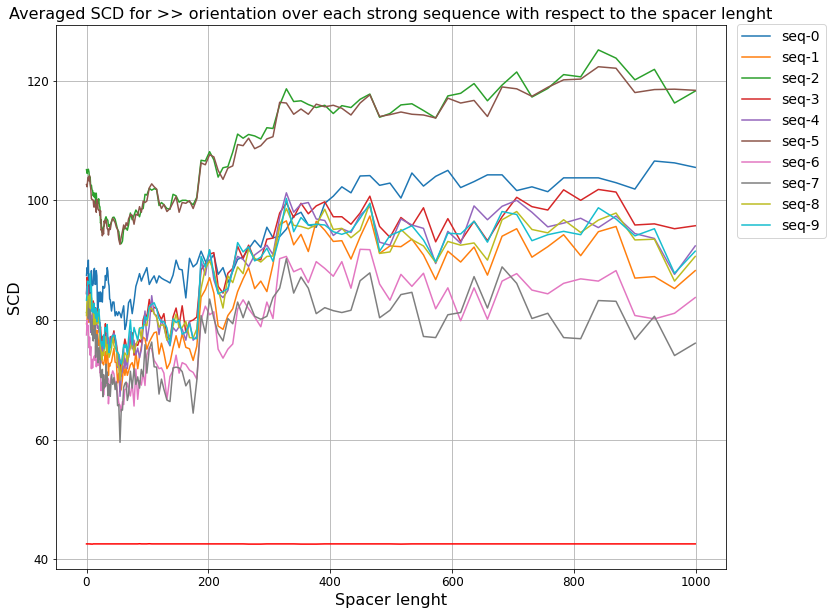

In [29]:
plt.figure(figsize=(12,10))
x = spacing_list

for seq_idx in range(10):

    plt.plot(x, orientation_vs_spacing_sequence[orientation_vs_spacing_sequence["seq_index"] == seq_idx]["SCD_average"],
            label=f"seq-{seq_idx}")

# plt.plot(x, orientation_vs_spacing_sequence[orientation_vs_spacing_sequence["seq_index"] == median_seq_idx]["SCD_average"], c="red")

# blue line is average over all weak sequences
plt.plot(x, orientation_vs_spacer[(orientation_vs_spacer["strong"] == False)]["SCD_average"], 
         c="red")

plt.grid(True)
plt.title(f"Averaged SCD for >> orientation over each strong sequence with respect to the spacer lenght")
plt.xlabel("Spacer lenght")
plt.ylabel("SCD")
plt.legend(loc="lower right")
plt.legend(bbox_to_anchor=(1.16, 1.015), loc='upper right', ncol=1)
plt.savefig(f"all_sequences_SCD.png", bbox_inches="tight")

### zoom in to the 0-200bp interval

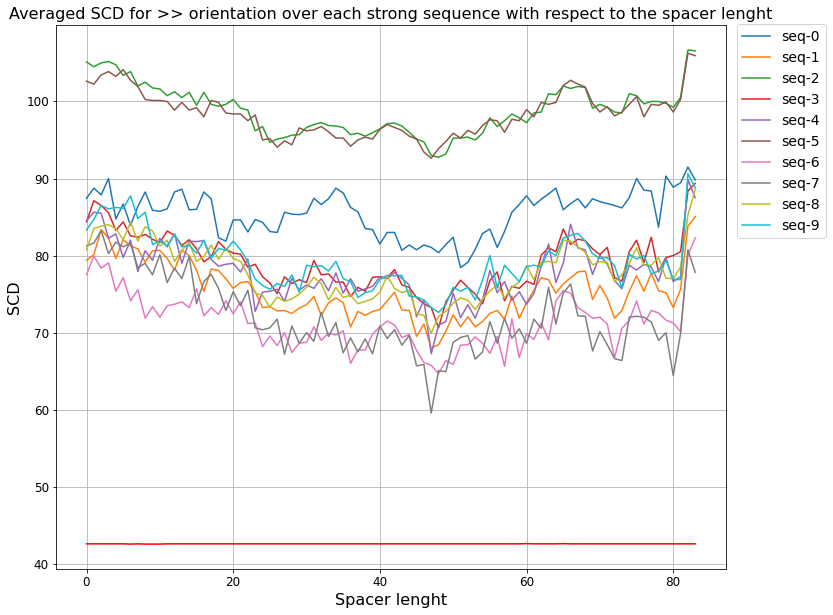

In [30]:
plt.figure(figsize=(12,10))
x = [i for i in range(len(spacing_list)) if spacing_list[i] <= 200]

for seq_idx in range(10):

    plt.plot(x, orientation_vs_spacing_sequence[(orientation_vs_spacing_sequence["seq_index"] == seq_idx) & (orientation_vs_spacing_sequence["spacer_bp"] <= 200)]["SCD_average"],
            label=f"seq-{seq_idx}")

# the red bottom line is average over all weak sequences
plt.plot(x, orientation_vs_spacer[(orientation_vs_spacer["strong"] == False) & (orientation_vs_spacer["spacer_bp"] <= 200)]["SCD_average"], c="red")

plt.grid(True)
plt.title(f"Averaged SCD for >> orientation over each strong sequence with respect to the spacer lenght")
plt.xlabel("Spacer lenght")
plt.ylabel("SCD")
# plt.legend(loc="upper left")
plt.legend(bbox_to_anchor=(1.16, 1.015), loc='upper right', ncol=1)
plt.savefig(f"sequences_SCD_zoomin.png", bbox_inches="tight")

### minimum for each sequence

In [31]:
print("{:<30} {:<30} {:<30}".format("Seq index", "Minimum SCD", "Corresponding spacer"))

for seq_idx in range(10):
    minimim_SCD = float(np.min(orientation_vs_spacing_sequence[orientation_vs_spacing_sequence["seq_index"] == seq_idx]["SCD_average"]))
    min_spacer = int(orientation_vs_spacing_sequence[(orientation_vs_spacing_sequence["seq_index"] == seq_idx) & (orientation_vs_spacing_sequence["SCD_average"] == minimim_SCD)]["spacer_bp"])
    
    print("{:<30} {:<30} {:<30}".format(seq_idx, minimim_SCD, min_spacer))

Seq index                      Minimum SCD                    Corresponding spacer          
0                              78.4375                        63                            
1                              68.0                           55                            
2                              92.75                          57                            
3                              70.625                         57                            
4                              67.25                          55                            
5                              92.625                         55                            
6                              64.6875                        57                            
7                              59.5625                        55                            
8                              69.9375                        55                            
9                              72.625                         57      